Predict the next data point given a current data point using an RNN

In [1]:
import torch
from torch import nn
import numpy as np
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

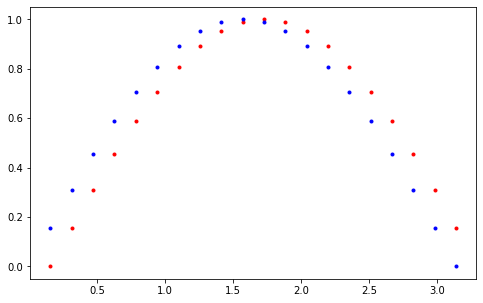

In [2]:
# creating training and target data

plt.figure(figsize=(8,5))

# data points in 1 batch
seq_length = 20

# generating evenly spaced data points
# start, end, num of points
time_steps = np.linspace(0, np.pi, seq_length+1)
data = np.sin(time_steps)
# reshaping the data to get another dimension (input_size)
# shape changed from (21,) to (21,1)
data.resize((seq_length + 1, 1))


x = data[:-1]
y = data[1:]

# display the data
plt.plot(time_steps[1:], x, 'r.', label='input, x')
plt.plot(time_steps[1:], y, 'b.', label='target, y')

In [3]:
# defining an RNN

# num_layers if it is greater than one it means we are stacking
# RNN takes in an input and a hidden state and produces output and another hidden state
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        # if batch=True then the input and output are provided as (batch,seq, feature)
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x, hidden):
        # specify how a batch of sequences will pass through this model
        batch_size = x.size(0)
        
        r_out, hidden = self.rnn(x, hidden)
        r_out = r_out.view(-1, self.hidden_dim)
        output = self.fc(r_out)
        return output, hidden
        

In [4]:
# instantiating and training the model

# model hyperparameters
input_size = 1
output_size = 1
hidden_dim = 32 # num of features I expect to generate
n_layers = 1 # n_layers is usually a num between 1 and 3

# instantiating the RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
rnn

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [5]:
# This is a regression problem. The data points are coordinate values.
# To compare the predicted and expected values we need a regression loss such as MSE

criterion = nn.MSELoss()
optimizer = optim.Adam(rnn.parameters(), lr = 0.01)

In [8]:
def train(rnn, n_steps, print_every):
    '''takes in the model, the number of steps to train for and a parameter
    to determine when to print the loss statistics'''
    
    hidden = None # this will default to a hidden state of all zeroes
    
    for batch_i, step in enumerate(range(n_steps)):
        # generating training data
        time_steps = np.linspace(step * np.pi, (step+1) * np.pi, seq_length + 1)
        data = np.sin(time_steps)
        data.resize((seq_length + 1, 1))
        
        x = data[:-1]
        y = data[1:]
        
        # convert data into tensors
        x_tensor = torch.Tensor(x).unsqueeze(0)
        y_tensor = torch.Tensor(y)
        
        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)
        
        # the new rnn is going to be fed into the rnn at the next time step
        # this detaches the new hidden state from its history so i don't have to backpropagate though a series of accumulated hidden states
        hidden = hidden.data
        
        # calc the loss
        loss = criterion(prediction, y_tensor)
        
        # zeroing any accumulated gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        # print the loss and show predictions
        if batch_i % print_every == 0:
            print('Loss: ', loss.item())
            plt.plot(time_steps[1:], x, 'r.')
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.')
            plt.show()
            
    return rnn

Loss:  0.23515966534614563


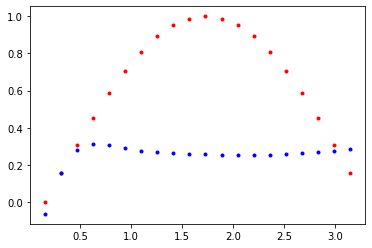

Loss:  0.058856986463069916


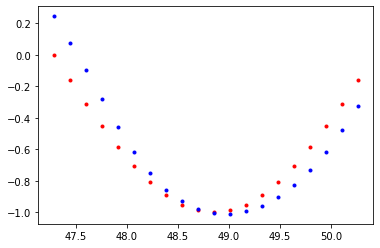

Loss:  0.0050054495222866535


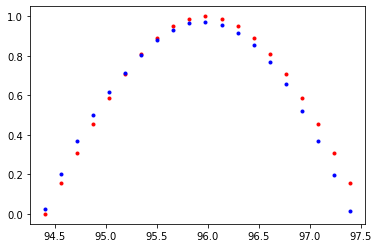

Loss:  0.0008361018262803555


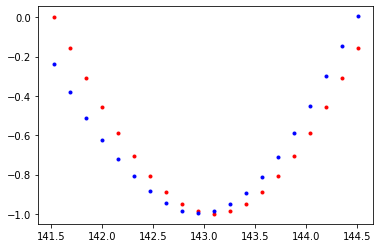

Loss:  0.0004437969473656267


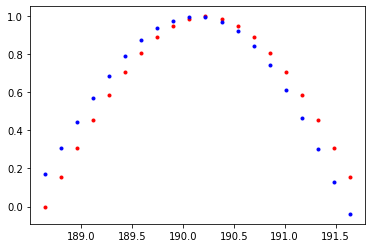

In [9]:
n_steps = 75
print_every = 15

trained_rnn = train(rnn, n_steps, print_every)

In [ ]:
# prediction
